# **Kelompok 5 - Trash Classification**
- Mytha Shabira
- Nadya Zahra Rahmadani
- Windi Noviani
- Fauziah Umri

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from glob import glob
import os

! pip install -q kaggle

In [2]:
from google.colab import files

# upload kaggle.json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umrim128y0212","key":"c3db5aaf007476003759fa8f22fb294d"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d techsash/waste-classification-data

 97% 415M/427M [00:04<00:00, 53.0MB/s]
100% 427M/427M [00:05<00:00, 88.0MB/s]


In [5]:
import zipfile,os
local_zip = '/content/waste-classification-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

root_dir = ('/content/DATASET/TRAIN')


In [6]:
# os.listdir('/tmp/DATASET/TRAIN')
# os.listdir('/tmp/DATASET/TEST')
os.listdir(root_dir)

['R', 'O']

In [7]:
import pathlib
def process(data):
  path = pathlib.Path(data)
  filepaths=list(path.glob(r"*/*.jpg"))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df=pd.concat([df1, df2],axis=1)
  return df

In [8]:
df_train= process(root_dir)

In [9]:
df_train

filepaths labels
0        /content/DATASET/TRAIN/R/R_766.jpg      R
1       /content/DATASET/TRAIN/R/R_5141.jpg      R
2       /content/DATASET/TRAIN/R/R_9362.jpg      R
3       /content/DATASET/TRAIN/R/R_7846.jpg      R
4       /content/DATASET/TRAIN/R/R_3009.jpg      R
...                                     ...    ...
22559   /content/DATASET/TRAIN/O/O_8291.jpg      O
22560   /content/DATASET/TRAIN/O/O_7573.jpg      O
22561  /content/DATASET/TRAIN/O/O_12049.jpg      O
22562   /content/DATASET/TRAIN/O/O_4659.jpg      O
22563   /content/DATASET/TRAIN/O/O_9513.jpg      O

[22564 rows x 2 columns]

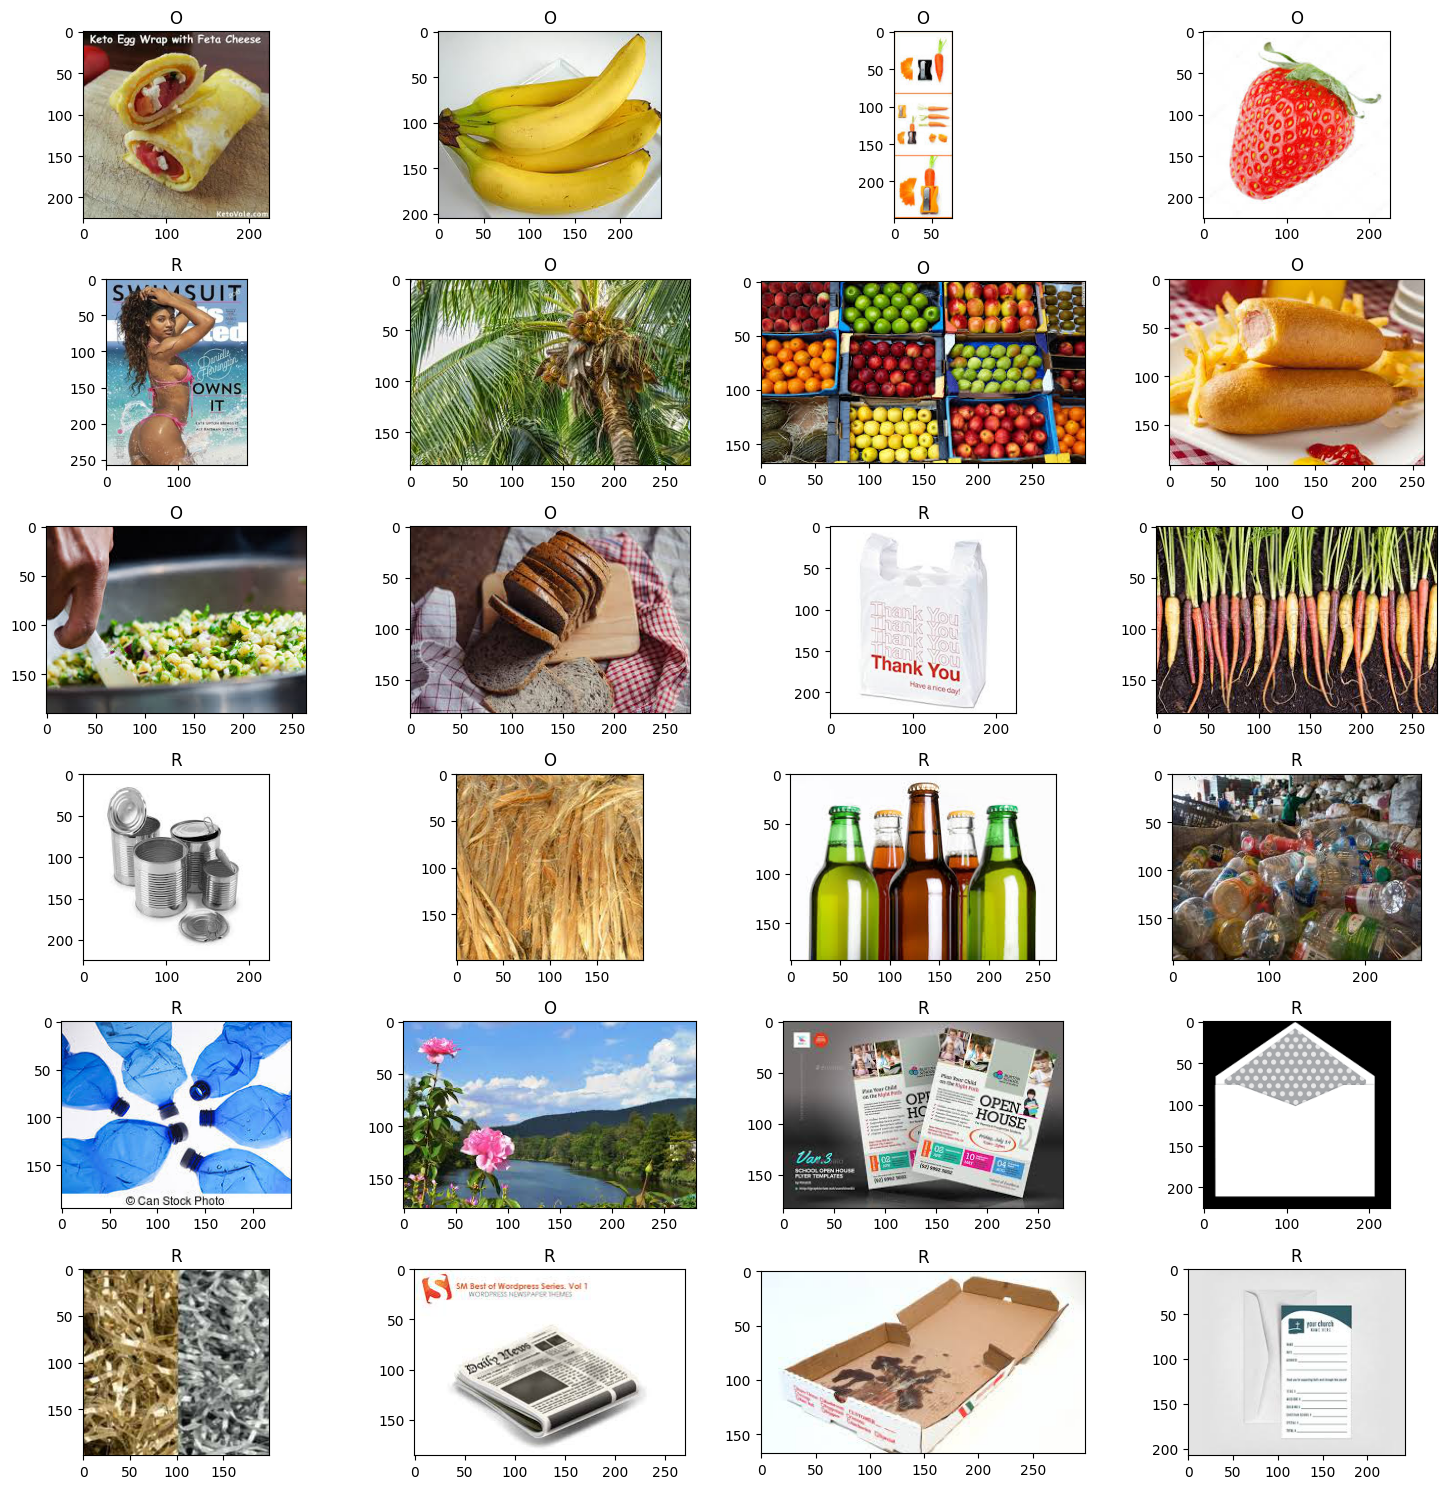

In [10]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
fig, axes=plt.subplots(nrows=6,ncols=4,figsize=(15,15))

for i,ax in enumerate(axes.flat):
  x=plt.imread(df_train['filepaths'][i])
  ax.imshow(x)
  ax.set_title(df_train['labels'][i])
plt.tight_layout()
plt.show()

In [11]:
x = (df_train.labels == 'O').sum()
y = (df_train.labels == 'R').sum()

print("Label Oganic pada Dataset ada", x)
print("Label Non-Organic pada Dataset ada", y)


Label Oganic pada Dataset ada 12565
Label Non-Organic pada Dataset ada 9999


In [12]:
classes=['Organic','Non-Organic']

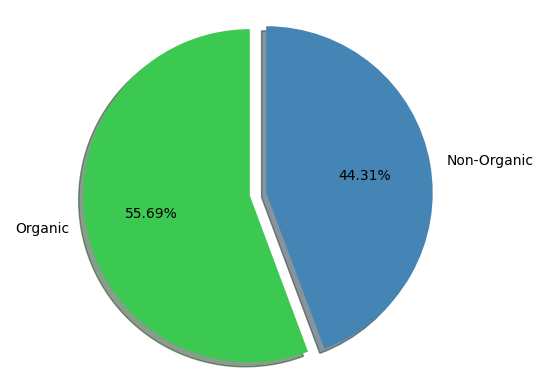

<Figure size 1000x800 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = classes
sizes = [x, y]
colors = ['#3BC951','#4485B5']
explode = (0.05, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
plt.figure(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

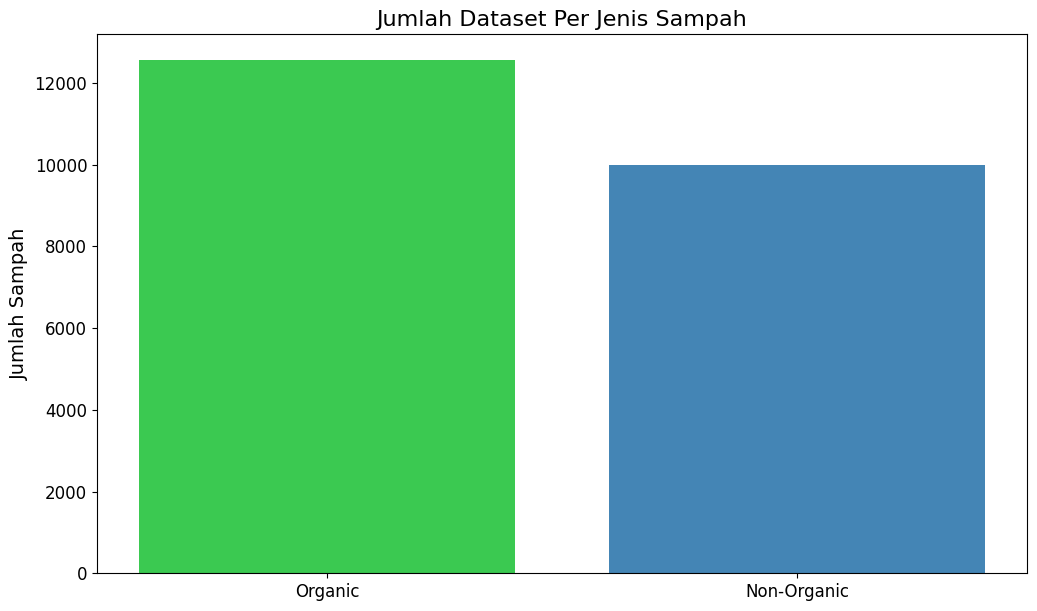

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

prodi = classes
jumlah_mhs = [x, y]
colors = ['#3BC951','#4485B5']

plt.figure(figsize=(12,7))
plt.bar(prodi, jumlah_mhs, color=colors)

plt.title('Jumlah Dataset Per Jenis Sampah', size=16)
plt.ylabel('Jumlah Sampah', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

Data preparation/preprocessing (Split Train 80% dan Test 20%)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

train_set = train_datagen.flow_from_dataframe(dataframe= df_train,
                                              x_col='filepaths',
                                              y_col='labels',
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              seed=42,
                                              subset='training',
                                              shuffle=True,
                                              class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_set = test_datagen.flow_from_dataframe(dataframe= df_train,
                                            x_col='filepaths',
                                            y_col='labels',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            color_mode='rgb',
                                            seed=42,
                                            subset='validation',
                                            class_mode = 'categorical')

Found 18052 validated image filenames belonging to 2 classes.
Found 4512 validated image filenames belonging to 2 classes.


In [16]:
# # Feature Extraction Layer
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# # Flatten feature map
# model.add(layers.Flatten())

# # Fully Connected Layer
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(2, activation='softmax'))

In [17]:
from tensorflow.keras.layers import Input

model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in model.layers:
    layer.trainable = False

last_output = model.output

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)



model = tf.keras.models.Model(model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/best-weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", #hdf5 = h5 (versi singkat)
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20)

In [20]:
optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer= optimizers ,loss = ('categorical_crossentropy'), metrics=['accuracy'])

history = model.fit(train_set,
                    epochs=6,
                    validation_data= test_set,
                    verbose=2,
                    callbacks=[callback_es, callback_cp],
                    validation_steps=5)

Epoch 1/6

Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /tmp/best-weights/weights-improvement-01-0.93.hdf5
565/565 - 233s - loss: 0.3226 - accuracy: 0.8671 - val_loss: 0.1976 - val_accuracy: 0.9250 - 233s/epoch - 412ms/step
Epoch 2/6

Epoch 2: val_accuracy did not improve from 0.92500
565/565 - 214s - loss: 0.2148 - accuracy: 0.9190 - val_loss: 0.2220 - val_accuracy: 0.9125 - 214s/epoch - 380ms/step
Epoch 3/6

Epoch 3: val_accuracy improved from 0.92500 to 0.96250, saving model to /tmp/best-weights/weights-improvement-03-0.96.hdf5
565/565 - 216s - loss: 0.1903 - accuracy: 0.9291 - val_loss: 0.1425 - val_accuracy: 0.9625 - 216s/epoch - 383ms/step
Epoch 4/6

Epoch 4: val_accuracy did not improve from 0.96250
565/565 - 212s - loss: 0.1699 - accuracy: 0.9346 - val_loss: 0.1657 - val_accuracy: 0.9438 - 212s/epoch - 376ms/step
Epoch 5/6

Epoch 5: val_accuracy did not improve from 0.96250
565/565 - 212s - loss: 0.1586 - accuracy: 0.9397 - val_loss: 0.1708 - val_accurac

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

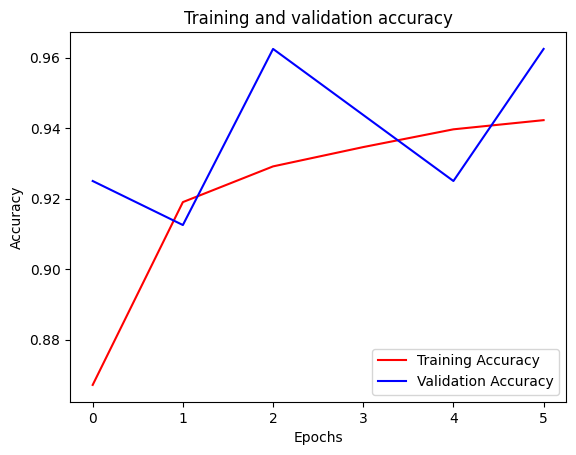

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(epochs, acc, 'r', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

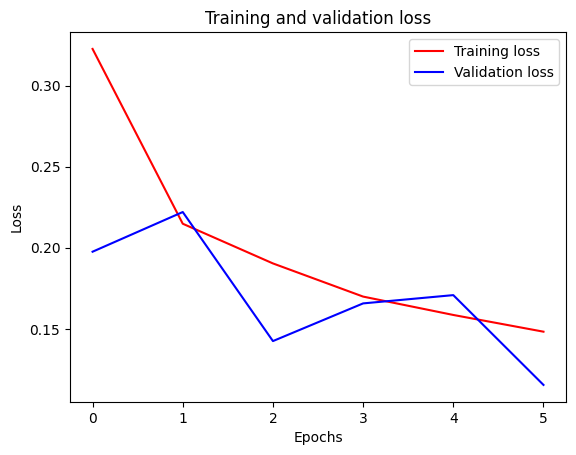

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Melakukan pengecekan Confussion Matrix

141/141 [==============================] - 12s 77ms/step


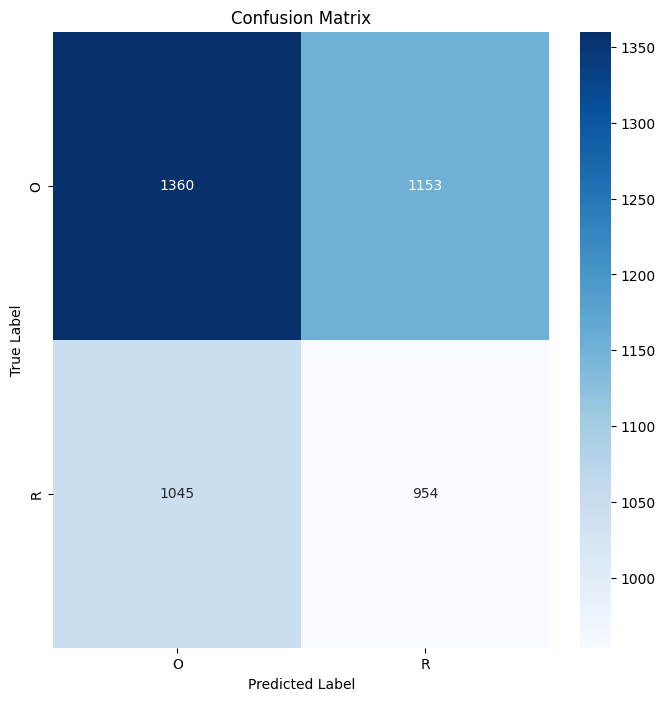

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hasil prediksi dari model terhadap data test
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Daftar label kelas (misal: ['class_0', 'class_1', ...])
class_labels = list(test_set.class_indices.keys())

# Plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Model Evaluation

1/1 [==============================] - 1s 752ms/step


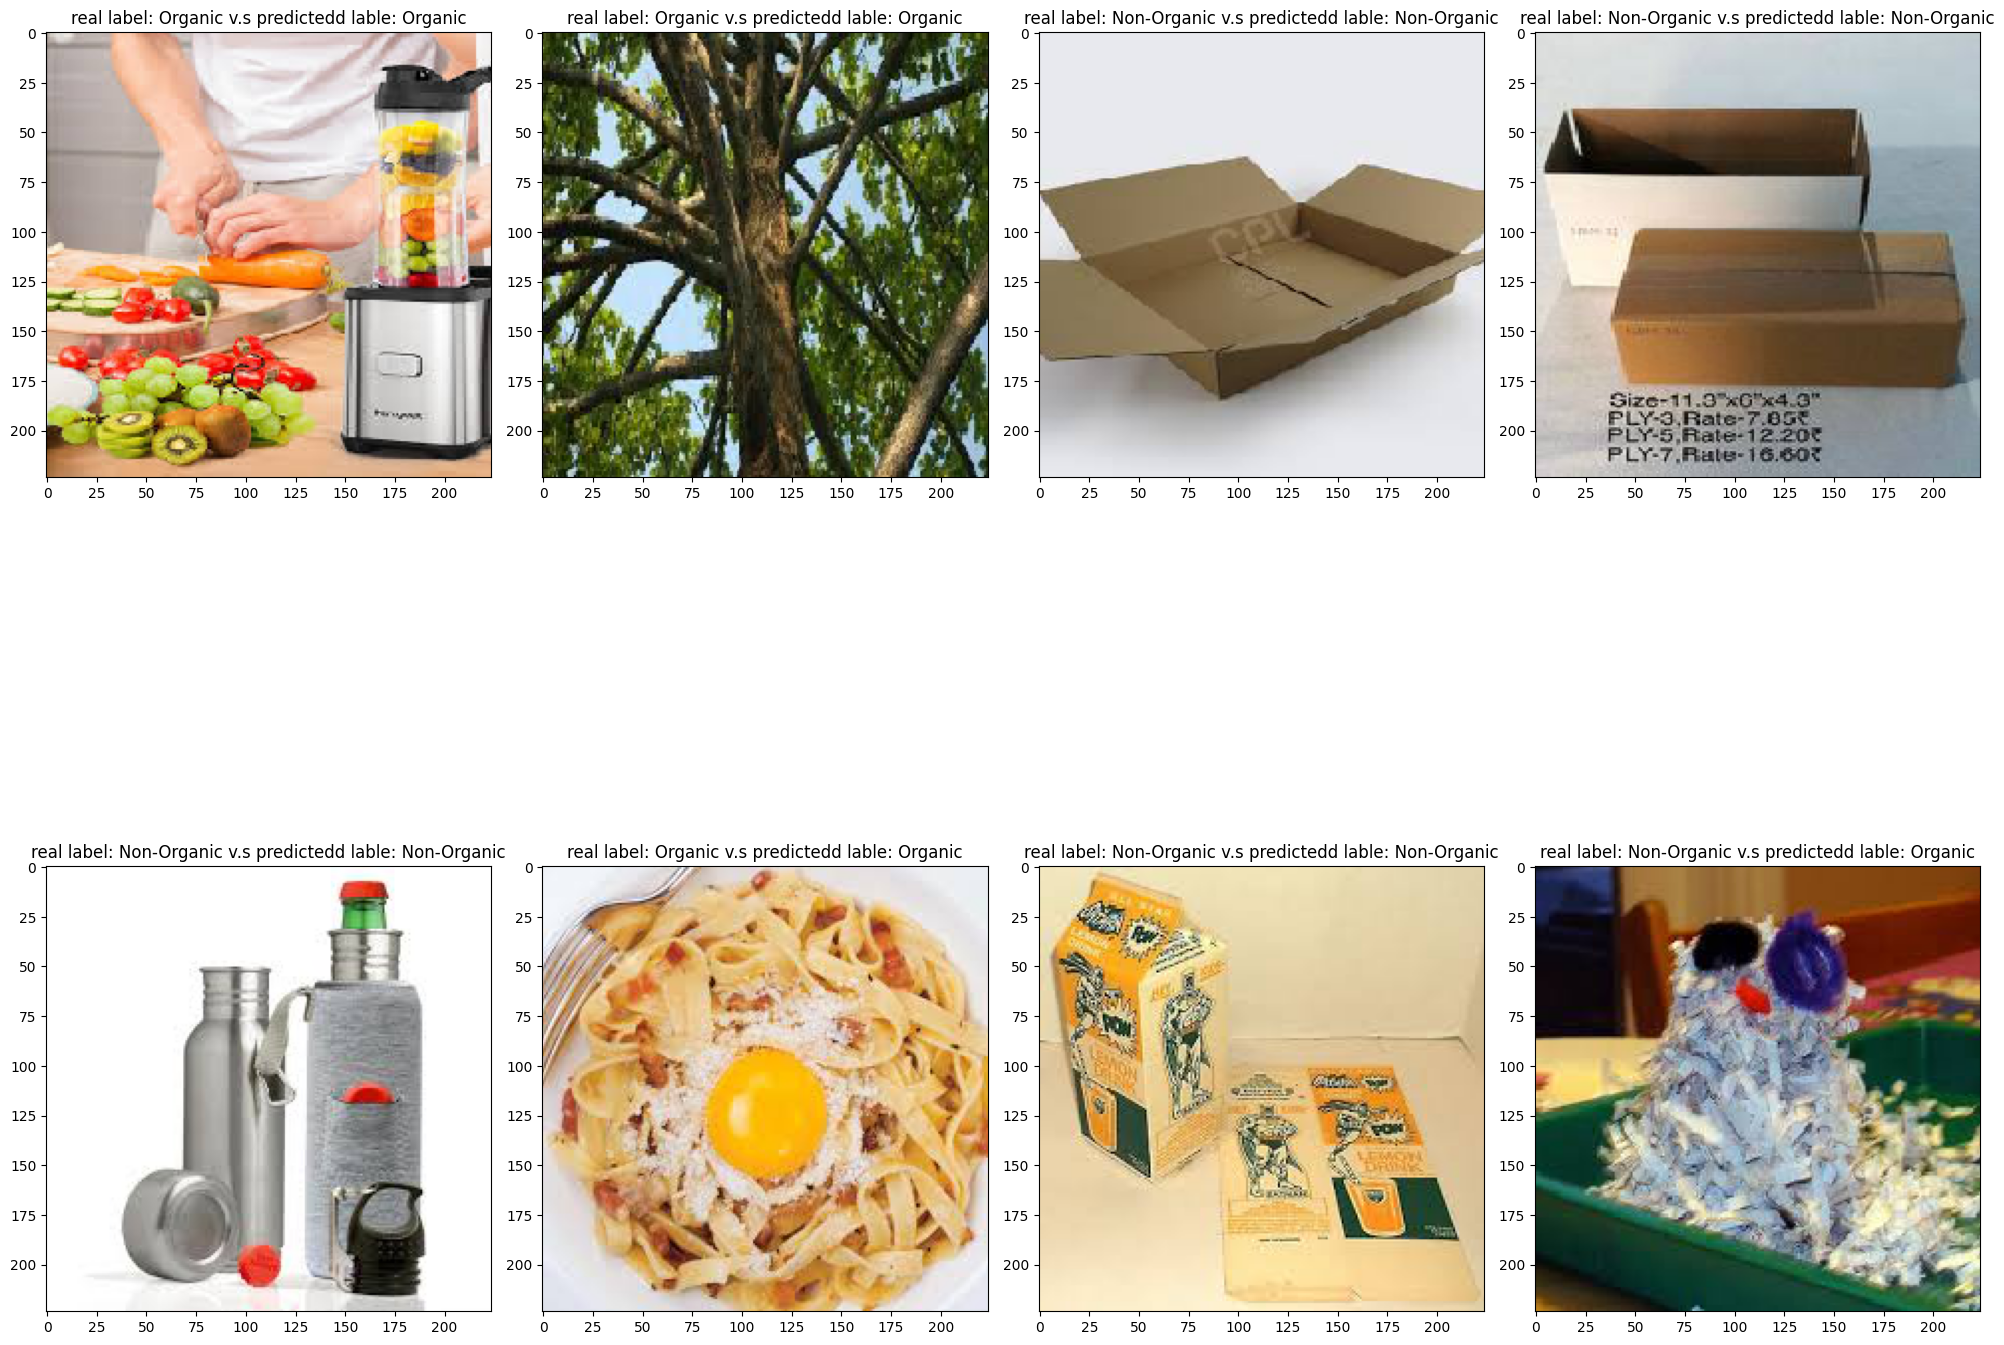

In [25]:
images, labels = test_set.next()
preds = model.predict(images)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(20,20))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,8):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(classes[label]) + " v.s " + "predictedd lable: " + str(classes[pred]))
    dic[i].imshow(image)
plt.tight_layout()
plt.show()